In [176]:
from __future__ import division
from code.organize import *
from code.roughEDA import *
from code.survey_processor import *

import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
sv = survey('data/survey/')

In [70]:
sv.num_processor()

In [71]:
df = sv.data

In [72]:
df.shape

(4504, 55)

In [73]:
df.columns

Index([u'sphrs1', u'agekdbrn', u'maeduc', u'maeduc_not_app', u'maeduc_dn_kwn',
       u'paeduc', u'paeduc_not_app', u'paeduc_dn_kwn', u'speduc',
       u'speduc_not_app', u'age', u'realinc', u'degree', u'mawrkgrw',
       u'incom16', u'natspac', u'nateduc', u'natarms', u'natfare', u'natsoc',
       u'natpark', u'natfarey', u'eqwlth', u'colath', u'colcom', u'spkhomo',
       u'affrmact', u'wrkwayup', u'hapmar', u'helpful', u'conbus', u'coneduc',
       u'conlabor', u'thnkself', u'workhard', u'helpoth', u'satjob',
       u'richwork', u'class_', u'satfin', u'finrela', u'getahead', u'kidssol',
       u'fepol', u'fechld', u'fepresch', u'fefam', u'helpsick', u'discaff',
       u'fejobaff', u'discaffm', u'discaffw', u'goodlife', u'meovrwrk',
       u'employed'],
      dtype='object')

In [80]:
temp = pd.crosstab(df.employed,df.natfare)

In [33]:
df_n = sv.fin_data

In [171]:
with open('data/survey/GSS.sps') as f:
    content = f.readlines()

In [199]:
for c in content:
    if c.strip()=='VALUE LABELS':
        ind = content.index(c)+1
lis = []
for i in xrange(ind,len(content)-2):
    if content[i].strip().strip('/').strip()[0].isalpha()==True:
        lis.append(i)
        

In [261]:
x = [(lis[i],lis[i+1]) for i in xrange(len(lis)-1) ]
x.append((lis[-1],len(content)-3))

In [422]:
from collections import defaultdict
d3 = {}
for k,v in d.iteritems():
    d2 = defaultdict(int)
    for i in v:
        text = " ".join(i.strip().split()[1:])
        d2[re.findall('"([^"]*)"', text)[0]] = int(i.strip().split()[0])
        d3[k] = d2

In [454]:
d4 = {}
for i in x:
    a = content[i[0]:i[1]]
    d4[a[0].strip().strip("/").strip().lower()] = a[1:]

In [8]:
s = sv.survey_cols

In [18]:
dictn = extr_val_labels('data/survey/GSS.sps')

In [10]:
for col in s[:-1]:
    df_r[col] = df_r[col].apply(lambda x: dictn[col][x])

In [81]:
temp

natfare,About right,Don't know,No answer,Not applicable,Too little,Too much
employed,,,,,,
False,241,25,1,869,212,263
True,378,63,4,1589,260,599


In [174]:
t = temp.apply(lambda x: x/ x.sum(), axis =1)

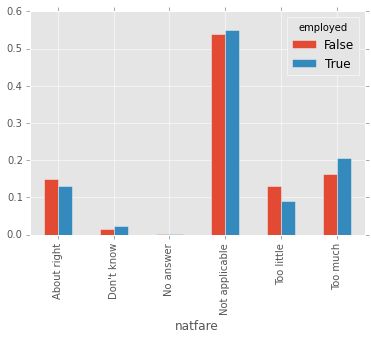

In [175]:
t.T.plot(kind = 'bar')


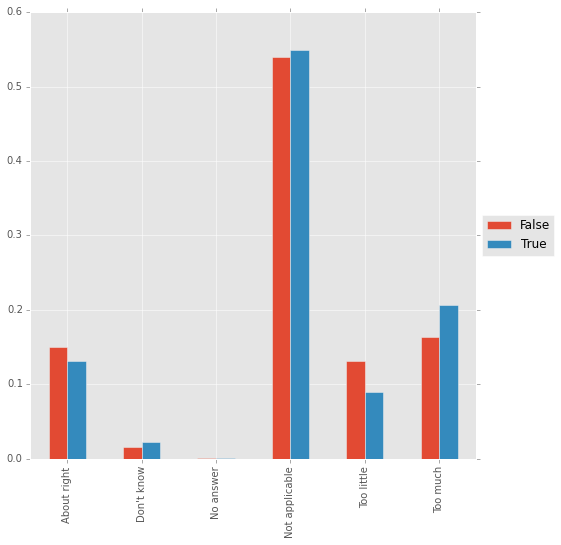

In [179]:
v_bar(df.employed,df.natfare)

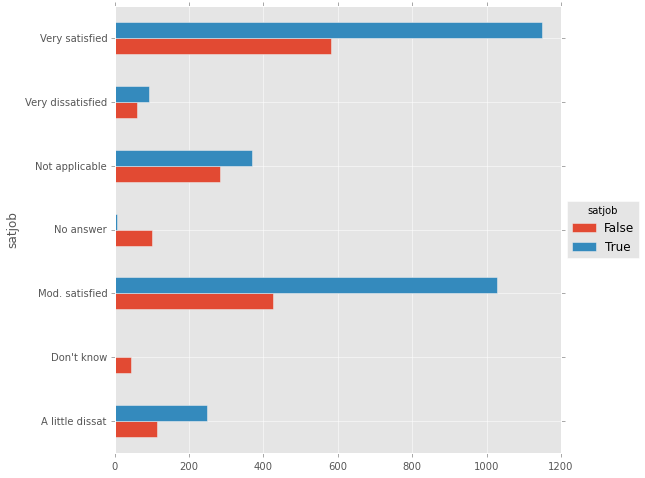

In [184]:
h_bar(df.satjob,df.employed)

In [137]:
a = df[['employed','paeduc']]

In [154]:
a.employed.name

'employed'

(0, 40)

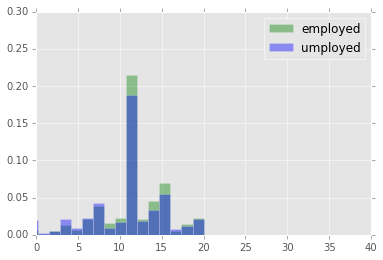

In [165]:
b = (0,40)
a[a.employed ==True]['paeduc'].hist(alpha = 0.4,bins = 90,color = 'green',label = 'employed',normed = True)
a[a.employed ==False].paeduc.hist(alpha =0.4,bins = 90,color = 'blue', label = 'umployed',normed = True)
plt.legend()

plt.xlim(b)

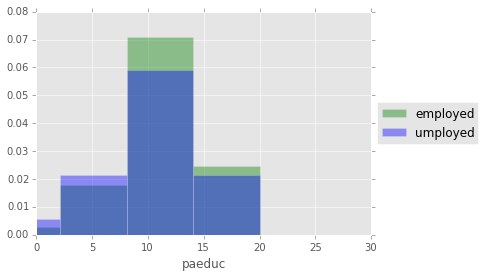